### 1. Imports et chargement des données


In [1]:
from dotenv import load_dotenv
import os

load_dotenv()
os.chdir("..")

In [2]:
# Imports généraux
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pathlib import Path

# Configuration des plots
plt.rcParams['figure.figsize'] = (10, 5)
sns.set_style("whitegrid")


In [3]:
# Chargement du DataFrame traité (daily)
processed_dir = Path("data/processed")
# Lister les fichiers processed daily
files = list(processed_dir.glob("*_processed_daily.parquet"))
# Choisir une zone
zone_file = files[0]
zone = zone_file.stem.replace("_processed_daily","")
df = pd.read_parquet(zone_file)
print(f"Zone analysée : {zone}")


Zone analysée : Baleares


In [4]:
# Aperçu global
df.info()
display(df.head())
display(df.describe().T)
print("Valeurs manquantes par colonne :")
print(df.isna().sum())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3653 entries, 2015-04-30 00:00:00+00:00 to 2025-04-29 00:00:00+00:00
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   temp_rmean_7          3653 non-null   float64
 1   temperature_2m        3653 non-null   float64
 2   lag_1d                3653 non-null   float64
 3   temp_rmean_6          3653 non-null   float64
 4   demand                3653 non-null   float64
 5   is_holiday            3653 non-null   int32  
 6   is_weekend            3653 non-null   int32  
 7   shortwave_radiation   3653 non-null   float64
 8   T_sq                  3653 non-null   float64
 9   temp_rmean_12         3653 non-null   float64
 10  temp_rmean_14         3653 non-null   float64
 11  lag_7d                3653 non-null   float64
 12  temp_rmean_24         3653 non-null   float64
 13  month                 3653 non-null   int32  
 14  temp_rmean_3          36

,temp_rmean_7,temperature_2m,lag_1d,temp_rmean_6,demand,is_holiday,is_weekend,shortwave_radiation,T_sq,temp_rmean_12,temp_rmean_14,lag_7d,temp_rmean_24,month,temp_rmean_3,temp_rmean_30,pvpc,relative_humidity_2m,WindChill,rmean_7d
datetime,,,,,,,,,,,,,,,,,,,,
2015-04-30 00:00:00+00:00,20.286905,15.000000,899.180,20.15,899.180,1,0,0.0,225.000000,20.397569,20.521726,899.18,19.962153,4,17.883333,19.901528,118.875000,94.000000,15.000000,11894.753857
2015-05-01 00:00:00+00:00,20.286905,18.537500,899.180,20.15,12730.749,1,0,6978.0,343.638906,20.397569,20.521726,899.18,19.962153,5,17.883333,19.901528,119.987083,73.458333,18.537500,11894.753857
2015-05-02 00:00:00+00:00,20.286905,20.112500,12730.749,20.15,13273.908,0,1,7326.0,404.512656,20.397569,20.521726,899.18,19.962153,5,17.883333,19.901528,116.262500,71.833333,20.112500,11894.753857
2015-05-03 00:00:00+00:00,20.286905,21.620833,13273.908,20.15,12655.341,0,1,7407.0,467.460434,20.397569,20.521726,899.18,19.962153,5,20.090278,19.901528,119.241667,58.250000,21.620833,11894.753857
2015-05-04 00:00:00+00:00,20.286905,23.454167,12655.341,20.15,14319.014,0,0,7063.0,550.097934,20.397569,20.521726,899.18,19.962153,5,21.729167,19.901528,114.228333,54.916667,23.454167,11894.753857


,count,mean,std,min,25%,50%,75%,max
temp_rmean_7,3653.0,18.372056,5.651881,7.346429,13.451190,17.569643,23.483929,29.858929
temperature_2m,3653.0,18.368139,5.782263,5.158333,13.529167,17.479167,23.466667,31.700000
lag_1d,3653.0,15465.903016,4336.896424,393.674000,13421.940000,14792.635000,17510.965000,27537.398000
temp_rmean_6,3653.0,18.371556,5.665238,7.220139,13.461806,17.612500,23.461806,30.082639
demand,3653.0,15469.955796,4330.192540,393.674000,13422.510000,14804.336000,17510.965000,27537.398000
is_holiday,3653.0,0.033397,0.179696,0.000000,0.000000,0.000000,0.000000,1.000000
is_weekend,3653.0,0.285792,0.451853,0.000000,0.000000,0.000000,1.000000,1.000000
shortwave_radiation,3653.0,4686.896797,2065.600876,0.000000,2771.000000,4563.000000,6607.000000,8277.000000
T_sq,3653.0,370.813925,220.750562,26.608403,183.038351,305.521267,550.684444,1004.890000
temp_rmean_12,3653.0,18.374619,5.601972,7.967361,13.403125,17.603819,23.532639,29.267361


Valeurs manquantes par colonne :
temp_rmean_7            0
temperature_2m          0
lag_1d                  0
temp_rmean_6            0
demand                  0
is_holiday              0
is_weekend              0
shortwave_radiation     0
T_sq                    0
temp_rmean_12           0
temp_rmean_14           0
lag_7d                  0
temp_rmean_24           0
month                   0
temp_rmean_3            0
temp_rmean_30           0
pvpc                    0
relative_humidity_2m    0
WindChill               0
rmean_7d                0
dtype: int64


### 4. Série temporelle de la demande


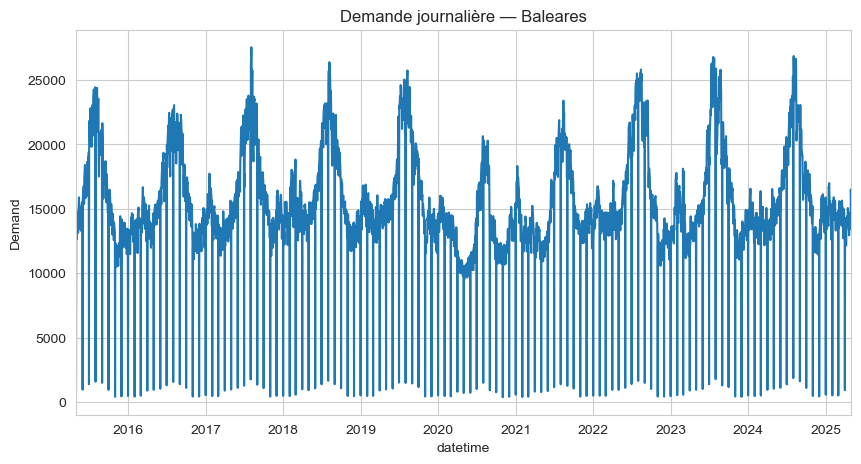

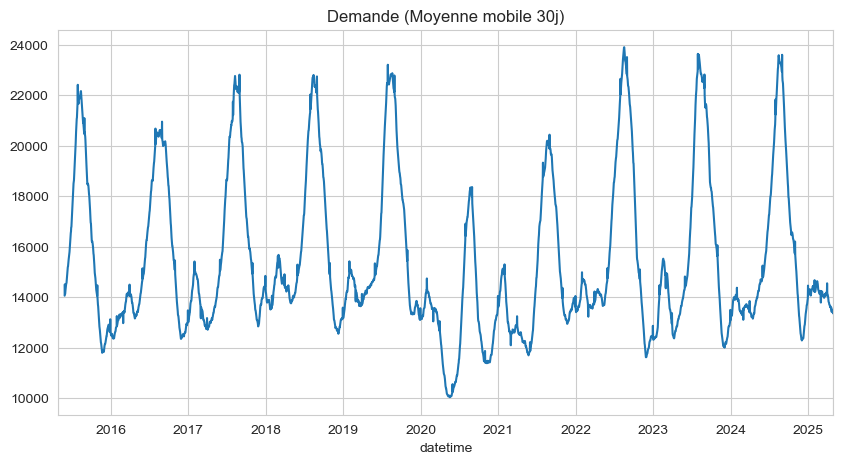

In [5]:
# 4. Série temporelle de la demande
plt.figure()
df['demand'].plot(title=f"Demande journalière — {zone}")
plt.ylabel("Demand")
plt.show()

# Moyenne mobile sur 30 jours
df['demand'].rolling(30).mean().plot(title="Demande (Moyenne mobile 30j)")
plt.show()

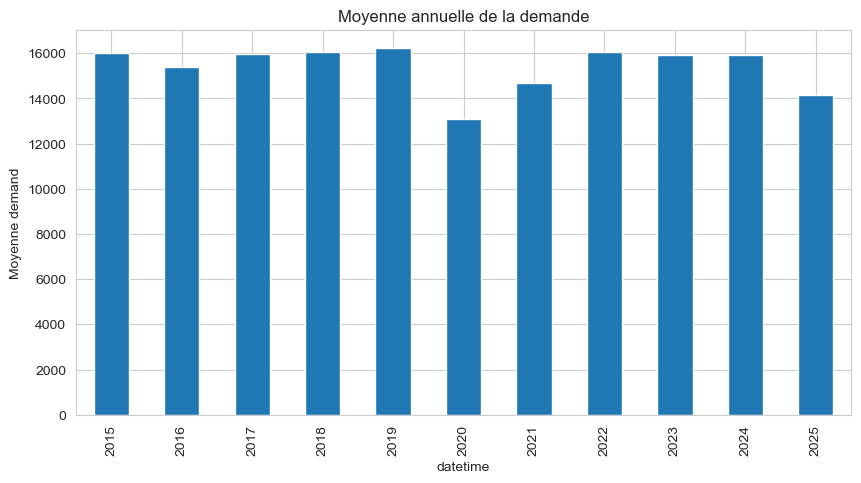

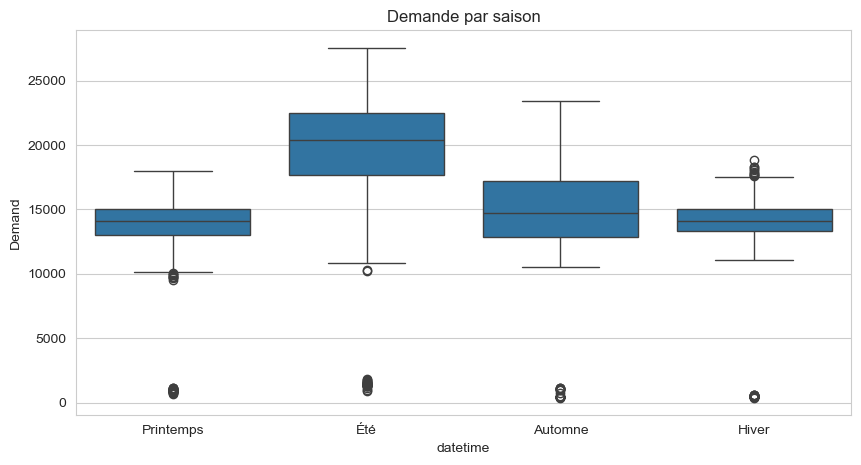

In [6]:
# 5. Boxplots par année et par saison
# Par année
df['demand'].groupby(df.index.year).mean().plot.bar(
    title="Moyenne annuelle de la demande")
plt.ylabel("Moyenne demand")
plt.show()

# Par saison
seasons = ((df.index.month%12 +3)//3).map({1:'Hiver',2:'Printemps',3:'Été',4:'Automne'})
plt.figure()
sns.boxplot(x=seasons, y=df['demand'])
plt.title("Demande par saison")
plt.ylabel("Demand")
plt.show()


### 6. Corrélations croisées

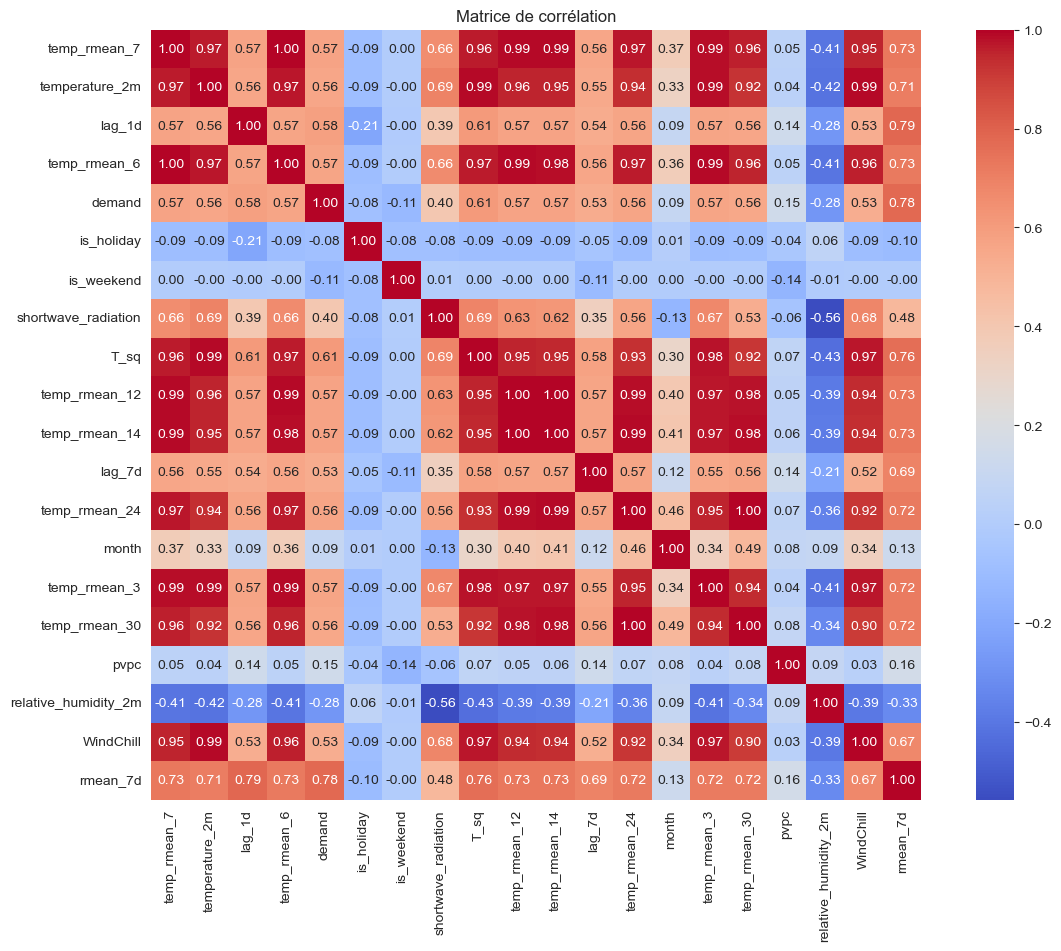

In [7]:
# 6. Corrélation des variables clés
# cols = ['demand','pvpc','temperature_2m','HDD','CDD','HeatIndex','WindChill']
corr = df.corr()
plt.figure(figsize=(14,10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matrice de corrélation")
plt.show()


### 7. Distribution de la demande et boxplot mensuel

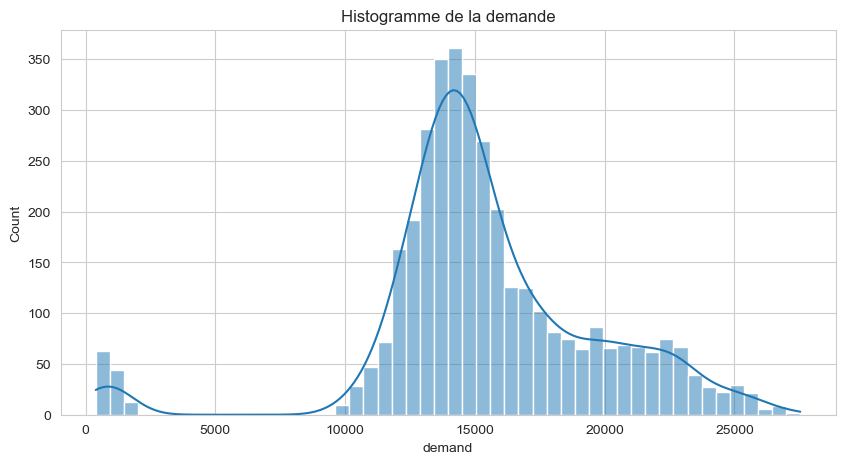

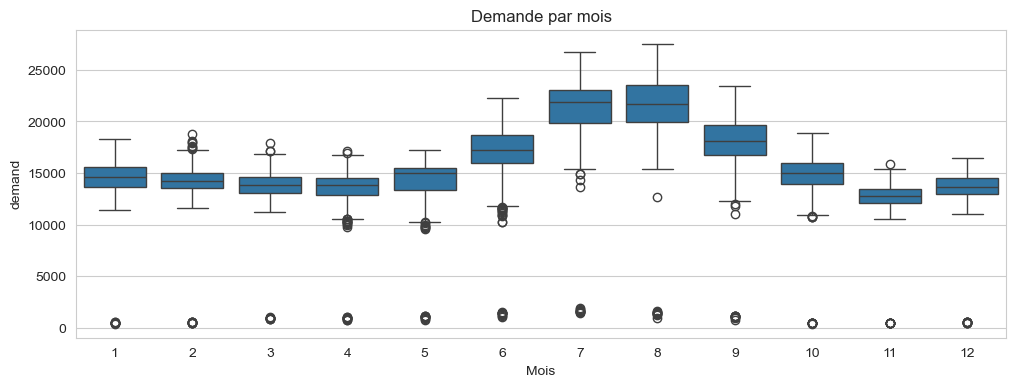

In [8]:
# 7. Distribution de la demande et boxplot mensuel
plt.figure()
sns.histplot(df['demand'], bins=50, kde=True)
plt.title("Histogramme de la demande")
plt.show()

plt.figure(figsize=(12,4))
sns.boxplot(x=df.index.month, y=df['demand'])
plt.title("Demande par mois")
plt.xlabel("Mois")
plt.show()


### 8. Analyse cyclique : jours de la semaine

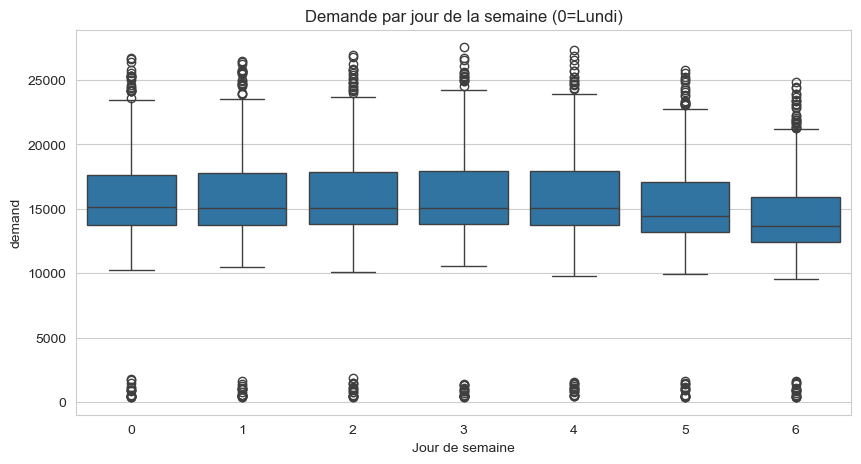

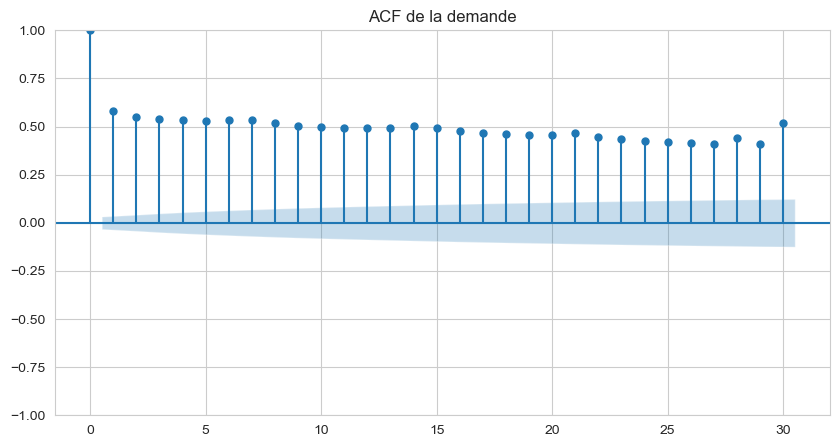

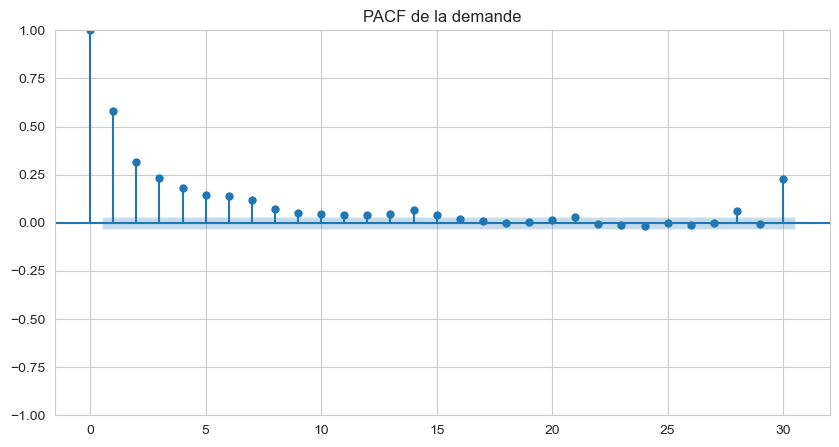

In [9]:
# 8. Analyse cyclique : jours de la semaine
plt.figure()
sns.boxplot(x=df.index.dayofweek, y=df['demand'])
plt.title("Demande par jour de la semaine (0=Lundi)")
plt.xlabel("Jour de semaine")
plt.show()

# Autocorrélation et PACF
plot_acf(df['demand'].dropna(), lags=30, title="ACF de la demande")
plt.show()
plot_pacf(df['demand'].dropna(), lags=30, title="PACF de la demande")
plt.show()


### 9. Effet des exogènes : scatter plots

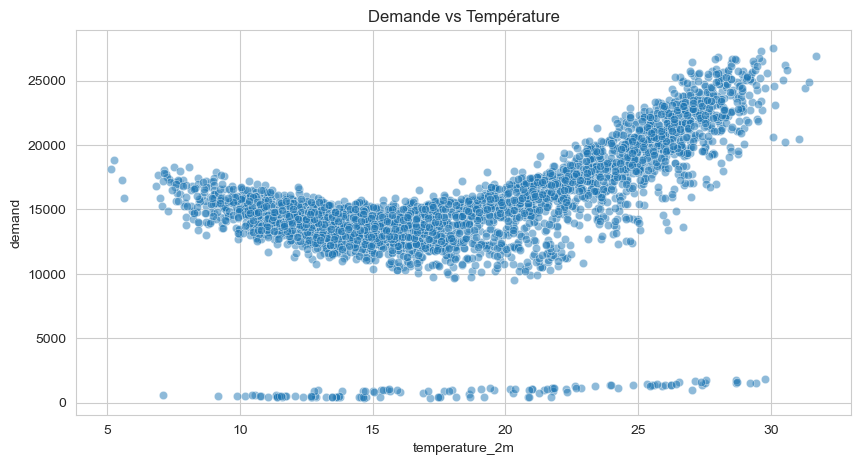

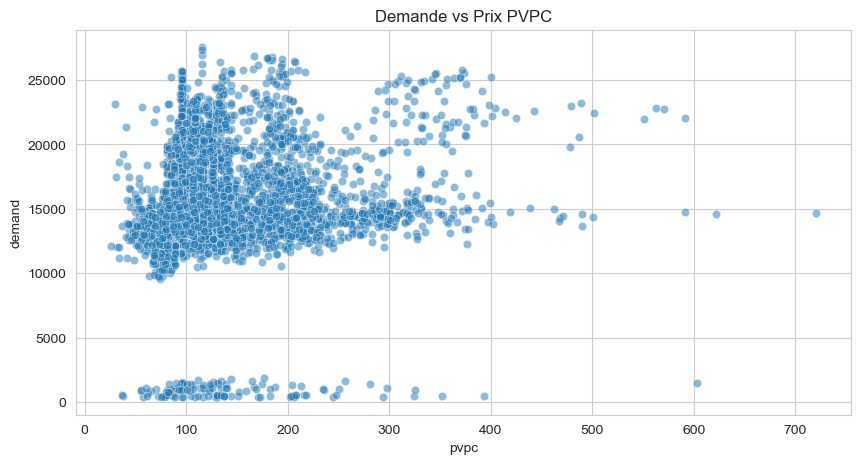

In [10]:
# 9. Effet des exogènes : scatter plots
plt.figure()
sns.scatterplot(x='temperature_2m', y='demand', data=df, alpha=0.5)
plt.title("Demande vs Température")
plt.show()

plt.figure()
sns.scatterplot(x='pvpc', y='demand', data=df, alpha=0.5)
plt.title("Demande vs Prix PVPC")
plt.show()


### 10. Démarche jours fériés vs ouvrés

<Figure size 1000x500 with 0 Axes>

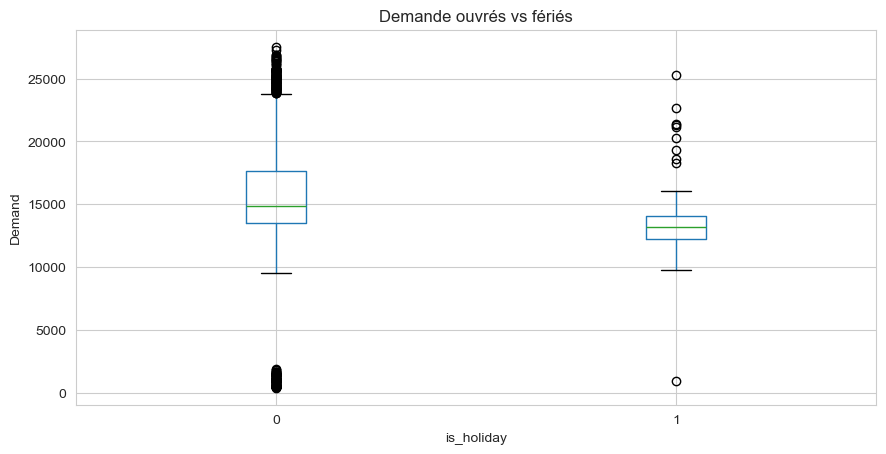

In [11]:
# Cellule 10. Démarche jours fériés vs ouvrés
plt.figure()
df.boxplot(column='demand', by='is_holiday')
plt.title("Demande ouvrés vs fériés")
plt.suptitle("")
plt.ylabel("Demand")
plt.show()



### 11. Détection d'anomalies (rolling z-score 7j)

Aucune anomalie (|z|>3) détectée


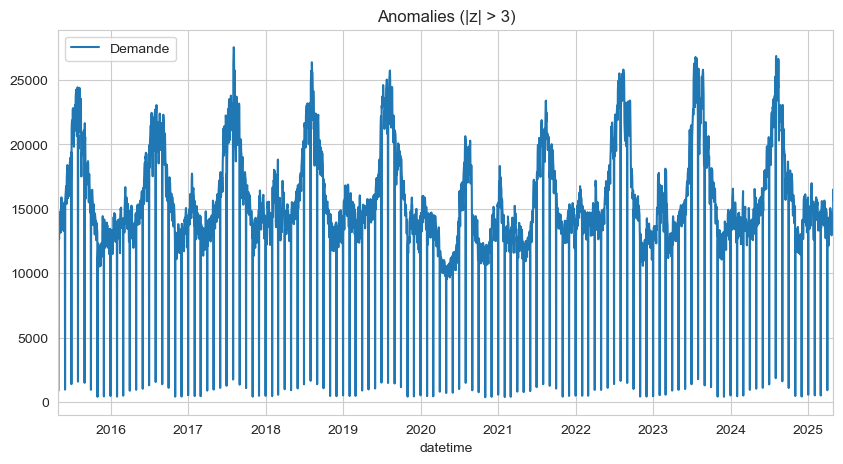

In [12]:
# 11. Détection d'anomalies (rolling z-score 7j)
rolling_mean = df['demand'].rolling(7).mean()
rolling_std  = df['demand'].rolling(7).std()
z_score = (df['demand'] - rolling_mean) / rolling_std

anoms = df[z_score.abs() > 3]
plt.figure()
df['demand'].plot(label='Demande')
if not anoms.empty:
    anoms['demand'].plot(style='ro', label='Anomalies')
else:
    print("Aucune anomalie (|z|>3) détectée")
plt.legend()
plt.title("Anomalies (|z| > 3)")
plt.show()


### 12. Conclusions textuelles


In [16]:
from IPython.display import Markdown
Markdown("""
**Conclusions provisoires :**
- **Tendances** : …
- **Saisonnalité** : …
- **Corrélations fortes** : ['rmean_7d', 'lag_1d', 'T_sq', 'temperature_2m',
 'temp_rmean_24h', 'temp_rmean_30h', 'HeatIndex', 'WindChill']
- **Anomalies détectées** : …
- **Prochaines étapes** : affiner features, tester modèles, valider stationnarité, etc.

         
     # Analyse des fonctions ACF et PACF de la demande

## Observations sur l'ACF (AutoCorrelation Function)
1. **Décroissance lente** : L'ACF montre une décroissance relativement lente vers zéro, ce qui est typique des processus non-stationnaires ou avec une tendance.
2. **Valeurs initiales élevées** : La corrélation à lag 1 est très élevée (proche de 1.00), ce qui suggère une forte dépendance entre les observations consécutives.
3. **Persistance des corrélations** : Les corrélations restent significatives pendant plusieurs périodes avant de diminuer.

## Observations sur la PACF (Partial AutoCorrelation Function)
1. **Pic significatif à lag 1** : La PACF présente un pic important au premier lag (environ 0.75) puis chute brutalement.
2. **Valeurs non significatives après lag 1** : Tous les lags suivants sont proches de zéro ou non significatifs.

## Interprétation et modélisation possible
1. **Processus AR(1)** : La forme de la PACF (un seul pic significatif) combinée avec la décroissance exponentielle de l'ACF suggère fortement un processus autorégressif d'ordre 1 (AR(1)).
2. **Équation potentielle** : Le modèle pourrait s'écrire: X_t = φX_{t-1} + ε_t, où φ ≈ 0.75 (estimé à partir du premier lag de la PACF).
3. **Stationnarité** : Comme le coefficient AR est inférieur à 1 en valeur absolue, le processus serait stationnaire.

""")



**Conclusions provisoires :**
- **Tendances** : …
- **Saisonnalité** : …
- **Corrélations fortes** : ['rmean_7d', 'lag_1d', 'T_sq', 'temperature_2m',
 'temp_rmean_24h', 'temp_rmean_30h', 'HeatIndex', 'WindChill']
- **Anomalies détectées** : …
- **Prochaines étapes** : affiner features, tester modèles, valider stationnarité, etc.

         
     # Analyse des fonctions ACF et PACF de la demande

## Observations sur l'ACF (AutoCorrelation Function)
1. **Décroissance lente** : L'ACF montre une décroissance relativement lente vers zéro, ce qui est typique des processus non-stationnaires ou avec une tendance.
2. **Valeurs initiales élevées** : La corrélation à lag 1 est très élevée (proche de 1.00), ce qui suggère une forte dépendance entre les observations consécutives.
3. **Persistance des corrélations** : Les corrélations restent significatives pendant plusieurs périodes avant de diminuer.

## Observations sur la PACF (Partial AutoCorrelation Function)
1. **Pic significatif à lag 1** : La PACF présente un pic important au premier lag (environ 0.75) puis chute brutalement.
2. **Valeurs non significatives après lag 1** : Tous les lags suivants sont proches de zéro ou non significatifs.

## Interprétation et modélisation possible
1. **Processus AR(1)** : La forme de la PACF (un seul pic significatif) combinée avec la décroissance exponentielle de l'ACF suggère fortement un processus autorégressif d'ordre 1 (AR(1)).
2. **Équation potentielle** : Le modèle pourrait s'écrire: X_t = φX_{t-1} + ε_t, où φ ≈ 0.75 (estimé à partir du premier lag de la PACF).
3. **Stationnarité** : Comme le coefficient AR est inférieur à 1 en valeur absolue, le processus serait stationnaire.

